In [115]:
import pandas as pd
import numpy as np
import numpy
import nltk

import simplejson as json
import csv
import os
import glob
import copy

import matplotlib.pyplot as plt
plt.close('all')

import re

In [116]:
# Read in each csv in the directory and cast to dataframes, accessible through list index

rootdir = r'C:\\Users\\kayle\\OneDrive\\Documents (OneDrive)\\ISchool\\2019 Summer\\Oxford\\HTRC-workingfiles\\HTRC-Meta-All'

path_list = []

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        filepath = os.path.join(subdir, file)
        path_list.append(filepath)

dataframes = [] 
for path in path_list:
    dataframes.append(pd.read_csv(path,
                                 encoding='utf-8',
                                  usecols=['001',
                                           '035',
                                           '040',
                                           '041',
                                           '245', 
                                           '500',
                                           '561',
                                           '563',
                                           '583',
                                           '600',
                                           '610', 
                                           '611', 
                                           '648', 
                                           '650', 
                                           '655', 
                                           '974']))

dataframes[0].head()

,001,035,040,041,245,500,561,563,583,600,610,611,648,650,655,974
0,862,[{'a': '(OCoLC)72294'}],"[{'a': 'DLC'}, {'c': 'DLC'}, {'d': 'OCL'}, {'d...",MISSING,"[{'a': 'Technology and world trade :'}, {'b': ...","[{'a': '""Sponsored by the Secretary of Commerc...",MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,"[{'a': 'Technology'}, {'v': 'Congresses.'}]",MISSING,"[{'8': 'ia.technologyworldt00symp'}, {'b': 'PS..."
1,2176,[{'a': '(OCoLC)146592'}],"[{'a': 'DLC'}, {'c': 'DLC'}, {'d': 'CWR'}, {'d...",MISSING,"[{'a': 'Republic of Korea /'}, {'c': '[by T. M...","[{'a': '""A United States Department of Commerc...",MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,"[{'8': 'ia.republicofkoreab00krac'}, {'b': 'PS..."
2,2530,[{'a': '(OCoLC)166684'}],"[{'a': 'Washington, D.C. Public Library'}, {'c...",MISSING,"[{'a': 'The gorgeous East,'}, {'b': 'India, Bu...",[{'a': 'Series title also at head of t.p.'}],MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,"[{'8': 'ia.gorgeouseastindi00eliaiala'}, {'b':..."
3,2718,[{'a': '(OCoLC)184573'}],"[{'a': 'OKentU'}, {'c': 'PAU'}]",MISSING,"[{'a': 'The loving ballad of Lord Bateman /'},...",[{'a': 'An adaptation of the traditional balla...,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,"[{'a': 'Poetry, English.'}]",MISSING,"[{'8': 'ia.lovingballadoflo00dick'}, {'b': 'CM..."
4,4067,[{'9': '(DLC) 02001319'}],"[{'a': 'DLC'}, {'c': 'OKentU'}, {'d': 'OCoLC'}...",MISSING,"[{'a': 'A Frenchman in America.'}, {'b': 'Reco...",MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,MISSING,"[{'8': 'ia.frenchmaninameri00orel'}, {'b': 'LO..."


# Data Cleaning
Clean up the textual data for all cells: lowercase, punctuation, tokenize, lemmatize, p-o-s

In [117]:
## Iterator pattern
# i = 0
# for frame in dataframes:
#     i += 1

# subsetting
# dfTest = dataframes
# dfTest[i][['500','583']]

In [129]:
# Convert "Missing" to empty string. 

i = 0

for frame in dataframes:
    dataframes[i] = dataframes[i].replace(to_replace='MISSING', value='')
    i += 1

In [130]:
### Extract relevant subfields from data: get only the needed values

### Scratch ###
# level 1: all the keys, values in one column
#      level 2: iterate over the list of dictionaries
#          level 3: iterate over the items in the dictionaries
# Goals:
# Be able to extract & manipulate subfields independently
### so we... assign values to the extracted values, cast them to new df's. They live in both places.



# for label, content in df['974'].items():
#     t = content
#     new_list = [i[0] for i in t]
#     print(label)
#     print(content, sep='\n')


###### attempt: 7/24
# for label, content in df['600'].items(): # one level deep. 
#     t = content
#     new_list = [i[0] for i in t]
#     for i in t:  # the item and the tuple-- the "count" and the list which contains the dictionaries
#         for t in d:     # for dictionary in the list
#             for key, value in d.items(): # the actual dictionary 
#                 print(key, value)

# for label, content in df['600'].items():
#     t = content
# #   print(t) # gets every list of dictionaries.
#     for i in t:
        


With each transformation to the dataset, the dataframes are assigned to a new variable so it can be accessed at a later point if needed. Simple variable assignment, such as new_list = old_list, copies only the list, thus each dataframe continues to be modified. Instead, copy.deepcopy(x) is used in order to capture both the list and its objects, the dataframes. 

In [131]:
def clean_lower(self):
    return self.str.lower()

def clean_punct(self):
    return self.str.replace('[^\w\s]','')

dfClean = copy.deepcopy(dataframes)

i = 0

for frame in dataframes:
    dfClean[i] = dfClean[i].select_dtypes(include='object').apply(clean_lower)
    dfClean[i] = dfClean[i].select_dtypes(include='object').apply(clean_punct)
    i += 0
dfClean[0].head()    

,035,040,041,245,500,561,563,583,600,610,611,648,650,655,974
0,a ocolc72294,a dlc c dlc d ocl d dnu d oclcq d nlggc d btct...,,a technology and world trade b proceedings c...,a sponsored by the secretary of commerce of th...,,,,,,,,a technology v congresses,,8 iatechnologyworldt00symp b pst c ipst d 2017...
1,a ocolc146592,a dlc c dlc d cwr d ocl d utorblw,,a republic of korea c by t mark kraczkiewicz,a a united states department of commerce publi...,,,,,,,,,,8 iarepublicofkoreab00krac b pst c ipst d 2017...
2,a ocolc166684,a washington dc public library c oun d ocl d clu,,a the gorgeous east b india burma ceylon and s...,a series title also at head of tp,,,,,,,,,,8 iagorgeouseastindi00eliaiala b uc c isrlf d ...
3,a ocolc184573,a okentu c pau,,a the loving ballad of lord bateman c illustr...,a an adaptation of the traditional ballad by d...,,,,,,,,a poetry english,,8 ialovingballadoflo00dick b cmalg c gri d 201...
4,9 dlc 02001319,a dlc c okentu d ocolc d cod d dlc,,a a frenchman in america b recollections of me...,,,,,,,,,,,8 iafrenchmaninameri00orel b loc c iloc d 2013...


In [132]:
# Stopwords.
from nltk.corpus import stopwords
stop = stopwords.words('english')

pat = r'\b(?:{})\b'.format('|'.join(stop))

dfStop = copy.deepcopy(dfClean)

def clean_stop(self):
    self.str.replace(pat,'')
    self.str.replace(r'\s+', ' ')
    return self

i = 0

for frame in dfStop:
    dfStop[i] = dfStop[i].select_dtypes(include=object).apply(clean_stop)
    i += 0

In [133]:
# Tokenize
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# extract each series into dictionary or list and tokenize 
# iterate through dataframe by index

### General Notes


# tokens_500 = []

# for df in dfStop[i].index:      
#     t = str(dfStop['500'][i])
#     s_t = t.split()
#     tokens_500.append(s_t)
    
# word_list_500 = []

# for l in tokens_500:
#     word_list_500 = word_list_500 + l

### 561 Ownership

### 563 Binding
# tokens_563 = []
# for i in dfStop.index:
#     t = str(dfStop['563'][i])
#     s_t = t.split()
#     tokens_563.append(s_t)
    
# word_list_563 = []

# for l in tokens_583:
#     word_list_563 = word_list_563 + l


# ### 583 Action Notes
# tokens_583 = []
# for i in dfStop.index:
#     t = str(dfStop['583'][i])
#     s_t = t.split()
#     tokens_583.append(s_t)
    
# word_list_583 = []

# for l in tokens_583:
#     word_list_583 = word_list_583 + l

# ##### Subject fields

# ### 600
# tokens_600 = []
# for i in dfStop.index:
#     t = str(dfStop['600'][i])
#     s_t = t.split()
#     tokens_600.append(s_t)
    
# word_list_600 = []

# for l in tokens_600:
#     word_list_600 = word_list_600 + l

# ### 610
# tokens_610 = []
# for i in dfStop.index:
#     t = str(dfStop['610'][i])
#     s_t = t.split()
#     tokens_610.append(s_t)
    
# word_list_610 = []

# for l in tokens_610:
#     word_list_610 = word_list_610 + l
    
# ### 611
# tokens_611 = []
# for i in dfStop.index:
#     t = str(dfStop['611'][i])
#     s_t = t.split()
#     tokens_610.append(s_t)
    
# word_list_611 = []

# for l in tokens_611:
#     word_list_611 = word_list_611 + l

# ### 648
# tokens_648 = []
# for i in dfStop.index:
#     t = str(dfStop['648'][i])
#     s_t = t.split()
#     tokens_648.append(s_t)
    
# word_list_648 = []

# for l in tokens_648:
#     word_list_648 = word_list_648 + l

# ### 650
# tokens_650 = []
# for i in dfStop.index:
#     t = str(dfStop['650'][i])
#     s_t = t.split()
#     tokens_650.append(s_t)
    
# word_list_650 = []

# for l in tokens_650:
#     word_list_650 = word_list_650 + l

# ### 655
# tokens_655 = []
# for i in dfStop.index:
#     t = str(dfStop['655'][i])
#     s_t = t.split()
#     tokens_655.append(s_t)
    
# word_list_655 = []

# for l in tokens_655:
#     word_list_655 = word_list_655 + l

# Quantitative Study

* Percentage of records with data
* Amount of data per record (min, max, std)
* Data coverage by subject area
* Word Frequencies: 
    * most common words in the column
    * most common n-grams
    * most common words by subject area

In [134]:
# Count Characters & Create Columns
# Counts must be applied before stopwords, must not include subfield punctuation/noise

def char_counts(self):
    return self.map(str).apply(len)


dfCounts = copy.deepcopy(dfClean)

i = 0
for frame in dfCounts:
    dfCounts[i] = dfCounts[i].filter(['500', '561', '563', '583'], axis=1).select_dtypes(include=object).apply(char_counts)
    i += 1
    


In [137]:
# Number of Records with Data in the 583 Column
# Percentage of Records with Data in the 583 Column

i = 0
Data_583_Count = 0
Data_583_Perc = 0

for frame in dfCounts:
    s = pd.Series(dfCounts[i]['583'])
    Data_583_Count = Data_583_Count + dfCounts[i]['583'].where(s != 0).count()
    Data_583_Perc = Data_583_Perc + dfCounts[i]['583'].where(s != 0).count()/dfCounts[i]['583'].count()
    i += 1
    
print(Data_583_Count)
print(Data_583_Perc)

124
0.012400000000000001


In [53]:
# STATS: Create a dataframe showing record count, min, max, mean, and std
# Generate one row per file


# stats = pd.DataFrame(dfCounts['583'])

# for i in ActDF.index:
#     stats = stats_583.ActDF['583_Characters'](stats)

# stats = stats.describe()
# stats

i = -1
Data_583_Total = 0
Data_583_Max = 0
Data_583_Min = 0 
Data_583_Mean = 0 
Data_583_Std = 0

for frame in dfCounts:
    Data_583_Total = Data_583_Total + dfCounts[i]['583'].count()
    Data_583_Max = Data_583_Max + dfCounts[i]['583'].max()
    Data_583_Min = Data_583_Min + dfCounts[i]['583'].min()
    Data_583_Mean = Data_583_Mean + dfCounts[i]['583'].mean()
    Data_583_Std = Data_583_Std + dfCounts[i]['583'].std()
    
dfStats_583 = pd.DataFrame({'Total': Data_583_Total, 
                            'Max': Data_583_Max, 
                            'Min': Data_583_Min, 
                            'Mean': Data_583_Mean, 
                            'Std': Data_583_Std,
                            'With_Data': Data_583_Count,
                            'With_Data_Perc': Data_583_Perc}, index=[0]).T
dfStats_583

,0
Total,30000.000000
Max,351.000000
Min,21.000000
Mean,22.157100
Std,14.742047
With_Data,20001.000000
With_Data_Perc,2.000100


In [325]:
#! Output to CSV

# exportStats = dfStats_583.to_csv(r'Path name here.csv', index=False)

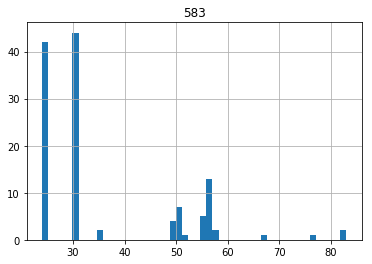

In [341]:
# Plot Character Counts
## Plot requires you to concat the data from all frames

# Concat numerical data in 583 Column
i = -1

df_WCounts_583 = dfCounts
for frame in df_WCounts_583:
    i += 1
    df_WCounts_583[i] = df_WCounts_583[i].filter(['583'], axis=1)
    
df_WCounts_583 = pd.concat(df_WCounts_583) 

# Generate series
s_583 = pd.Series(df_WCounts_583['583'])

# Generate Plot
Plot_WCounts_583 = df_WCounts_583.where(s_583 > 2).hist(column='583', bins=50)

In [342]:
# Ngram Frequency

from sklearn.feature_extraction.text import CountVectorizer

### 500
word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(dfClean['500'])
frequencies = sum(sparse_matrix).toarray()[0]
nGram500 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

### 583
word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(dfClean['583'])
frequencies = sum(sparse_matrix).toarray()[0]
nGram583 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

TypeError: list indices must be integers or slices, not str

In [144]:
# Creating dictionaries of word counts

from collections import Counter

counter500 = Counter(word_list_500)
counter563 = Counter(word_list_563)
counter583 = Counter(word_list_583)
counter600 = Counter(word_list_600)
counter610 = Counter(word_list_610)
counter611 = Counter(word_list_611)
counter648 = Counter(word_list_648)
counter655 = Counter(word_list_655)



In [113]:
# Frequency of Words, as Tokens

top_N = 30

word_dist = nltk.FreqDist(word_list_583)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                   columns=['Word', 'Frequency'])
print(rslt)

          Word  Frequency
0            3          1
1   rubenstein          1
2      library          1
3         copy          1
4            a          1
5       former          1
6         call          1
7       number          1
8            e          1
9          f88          1
10           v          1
11           6          1


# Coverage by Subject Area

For each subject field, we will gather the LCSH listed for rows where there is 583 data. From there, we can examine trends in the quantity of documentation by subject area. 


In [147]:
### Create dataframes where both conditions are met--data in 583 and subject data

### 600 
# subfields desired:
# a: personal Name
# x: general subdivision
sdf_600 = dfClean[['583','600','974']]
sdf_600.replace("", numpy.nan, inplace=True)
sdf_600[sdf_600['583'].notnull() & sdf_600['600'].notnull()]


### 610
sdf_610 = dfClean[['583','610','974']]
sdf_610.replace("", numpy.nan, inplace=True)
sdf_610 = sdf_610[sdf_610['583'].notnull() & sdf_610['610'].notnull()]


### 611
sdf_611 = dfClean[['583','611','974']]
sdf_611.replace("", numpy.nan, inplace=True)
sdf_611 = sdf_611[sdf_611['583'].notnull() & sdf_611['611'].notnull()]

### 648

sdf_648 = dfClean[['583','648','974']]
sdf_648.replace("", numpy.nan, inplace=True)
sdf_648 =  sdf_648[sdf_648['583'].notnull() & sdf_648['648'].notnull()]


### 650
sdf_650 = dfClean[['583','650','974']]
sdf_650.replace("", numpy.nan, inplace=True)
sdf_650 = sdf_650[sdf_650['583'].notnull() & sdf_650['650'].notnull()]


### 655

sdf_655 = dfClean[['583','655','974']]
sdf_655.replace("", numpy.nan, inplace=True)
sdf_655 = sdf_655[sdf_655['583'].notnull() & sdf_655['655'].notnull()]

# you now have a new dataframe for EACH 6XX where there is 583 data


# loop through where it is not null
# stats info
# try to get it into one dataframe

In [168]:
# Word of subjects which have 583 data
### we have tokenized the subject strings
### examine the most frequent terms
### Generate a plot

####### Pilot Test: Subject data for 500s ########

## creating dataframe
df_500x610 = df[['500','655','974']]
df_500x610.replace("", numpy.nan, inplace=True)
df_500x610 = df_500x610[df_500x610['500'].notnull() & df_500x610['655'].notnull()]

## We ONLY want tokens in the conditional dataframe... so let's run the tokenizer (we should really learn functions)
tokens_500x610 = []
for i in df_500x610.index:
    t = str(df_500x610['655'][i])
    s_t = t.split()
    tokens_500x610.append(s_t)
    
word_list_500x610 = []

for l in tokens_500x610:
    word_list_500x610 = word_list_500x610 + l
    


### Word Frequency
top_N = 30

word_dist = nltk.FreqDist(word_list_500x610)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                   columns=['Word', 'Frequency'])
# print(rslt)


' pictorial cloth bindings binding  england  1907  rbbin'

# Qualitative Study

In [ ]:
####### SUNDAY: 
# sentiment analysis
# text blob... tokenize and other stuff. POS tagging. classification and stuff
# --- nltk has a built-in ability
# text blob returns Objectivity --confidence in score
# and sentiment


In [ ]:
# notes: 
# list of tokens
# generate token lists -- most and least included
# fun: list of tokens by row


#### record level -- sentiment score by item.... ( for each row)
## macro... take all tokens -- sentiment score, for this field, by chunk
# by record for the field
# subject based

# select representative chunks -- 10k for each 
# specifics -- formally for this project
## numerically for this project
# accumulate for files

## completion of preservation conservation for one subset
# concat
# save the CSV... lots of CSVs... to_csv

In [ ]:
from textblob import TextBlob
zen = TextBlob("Hello, I've come here for an argument.")
for sentence in zen.sentences:
    print(sentence.sentiment)

In [ ]:
# Write a for loop to gather the sentiment and objectivity scores of.... rows? or sentence by sentence?
# clean data by punctuation, but NOT stopwords... 


# 583_sent_list = []

# for each row in df.index
# if the character count in df.index '583' is > than 0
##### 

# Analysis

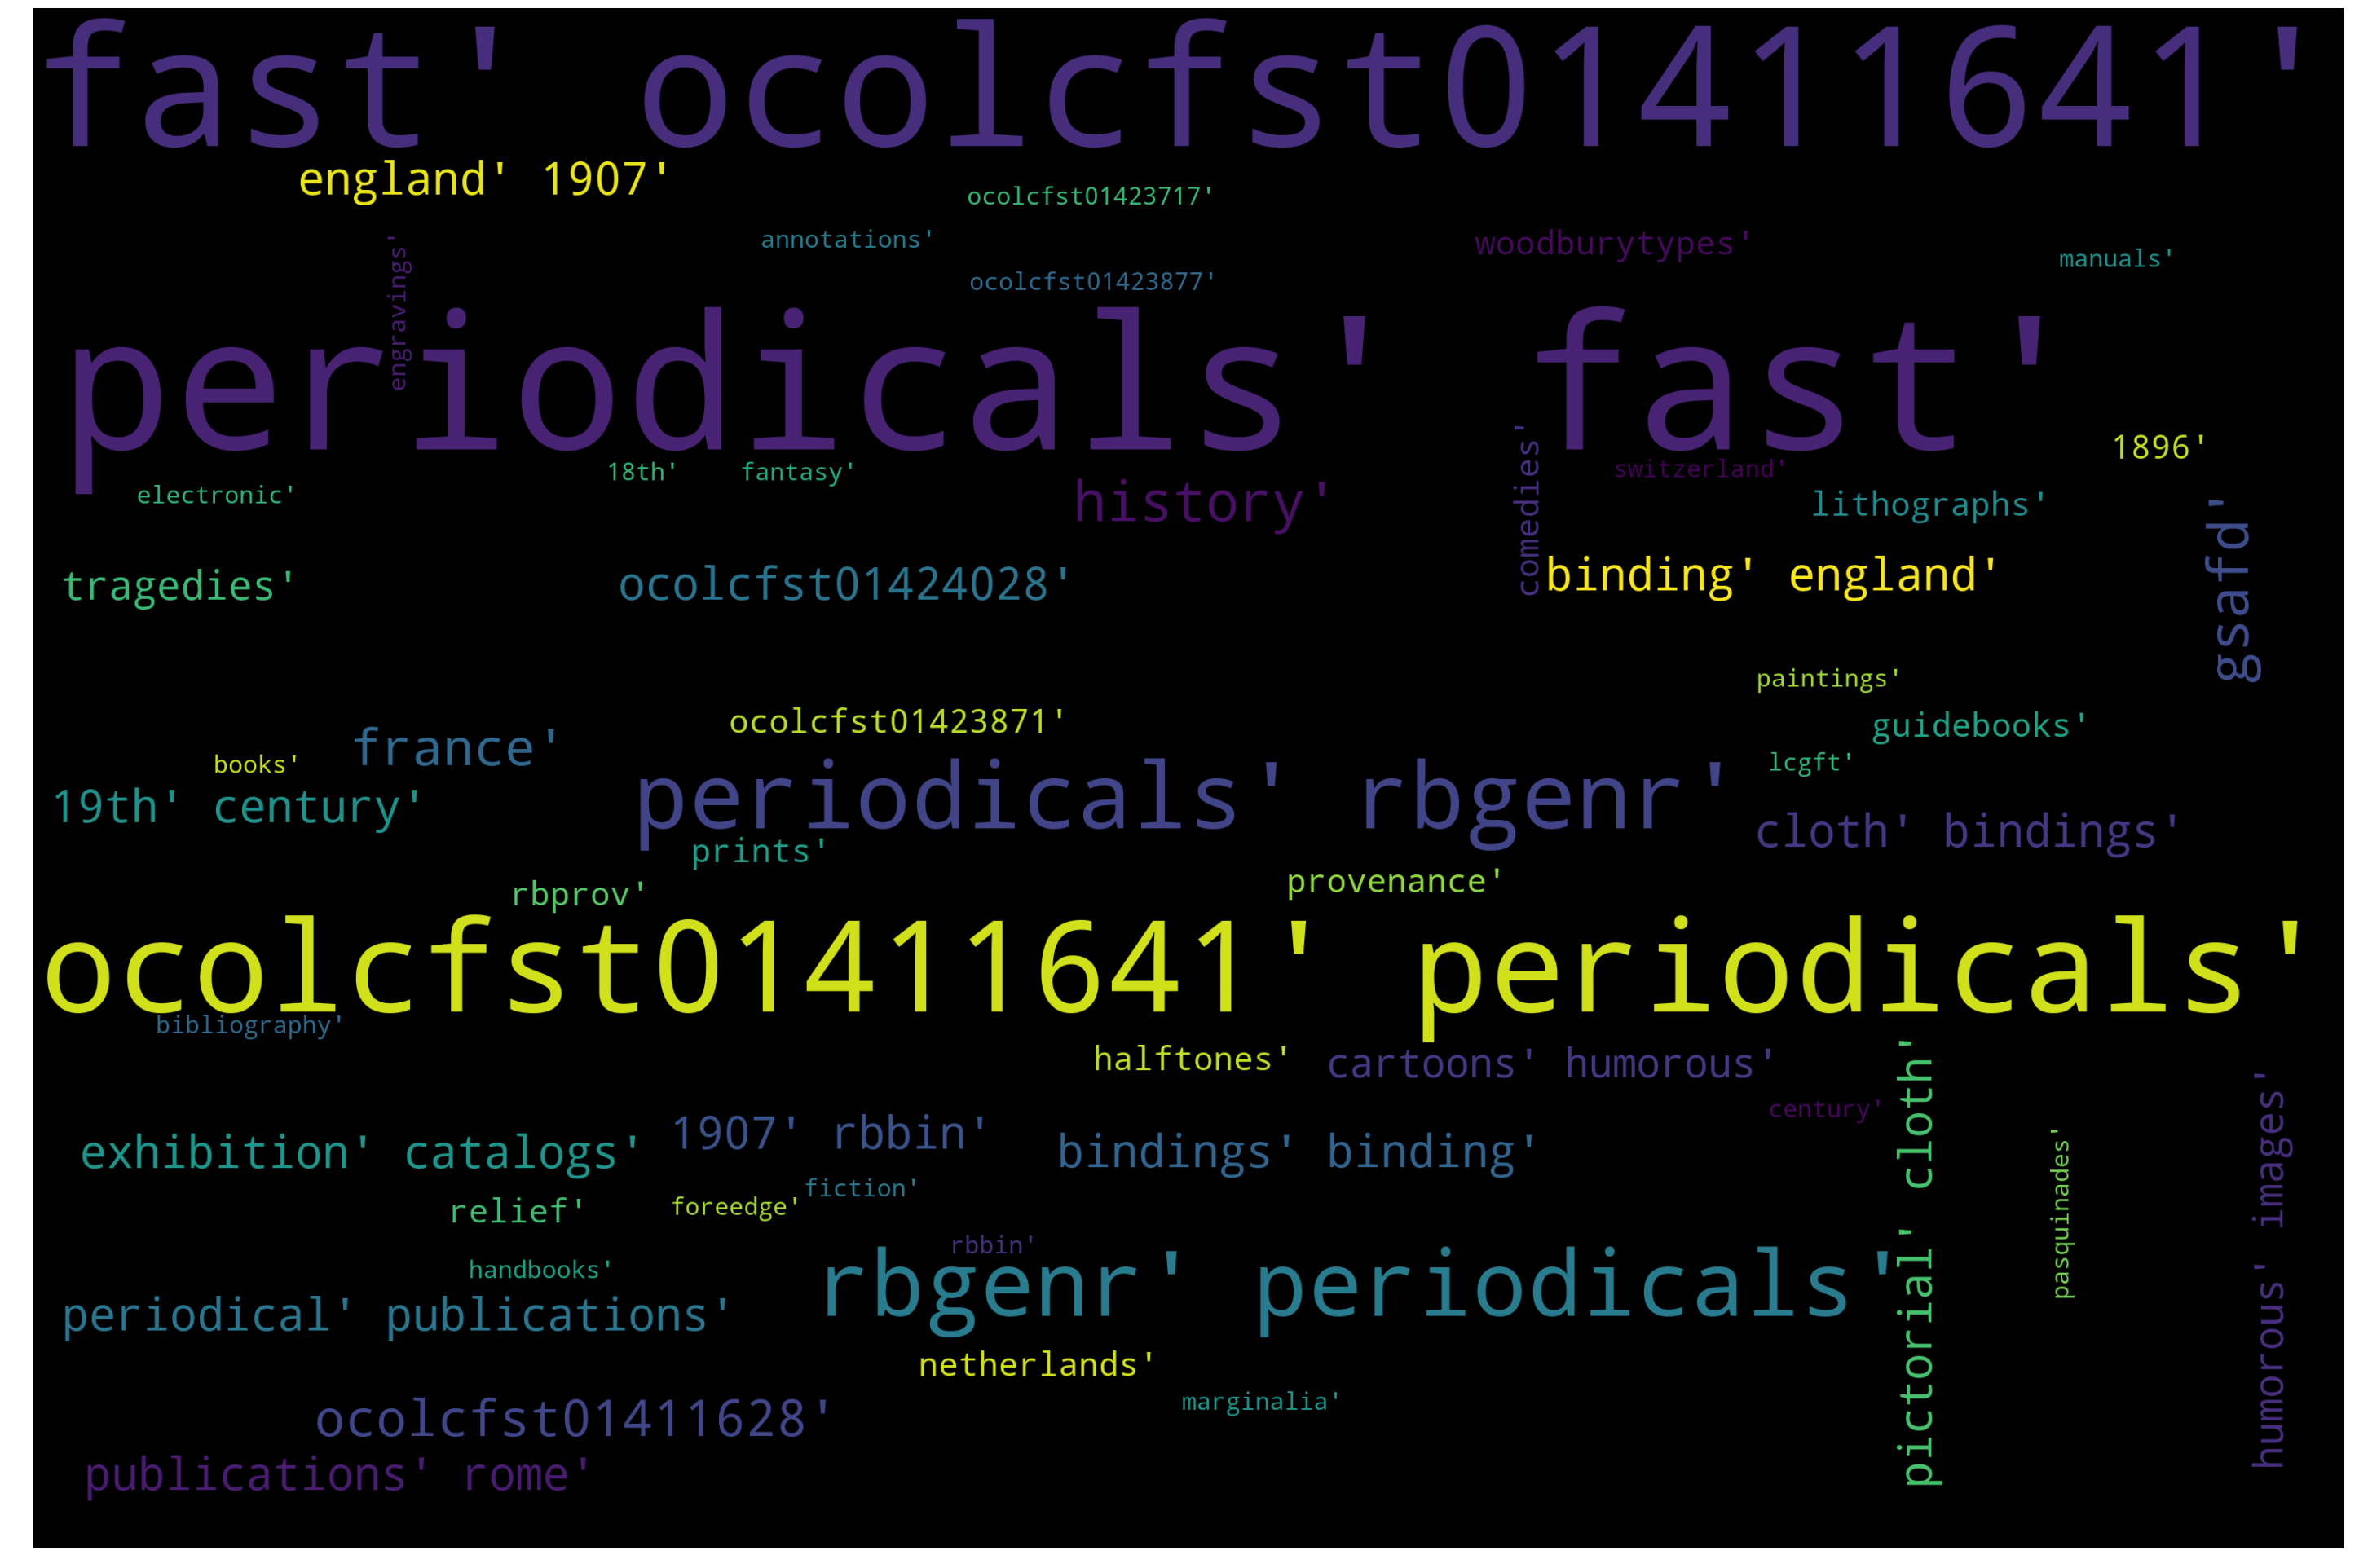

In [145]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = (word_list_500x610) # does not work with 583 ?
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(text))
fig = plt.figure(
    figsize = (40, 30))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# use fit_words to generate wordcoud from words and frequencies

In [ ]:
# check context of word in sentence
for i in df.index:
    a = str(df['583'][i])
    if 'library' in a:
        print(a)
    else:
        continue


# Scratch
* workflows to assess the quality of shared databases
* what are the challenges to identifying what is *in* the HT database to begin with?
    * lack of identifying numbers (OCLC)
    * title variants
        * CV software on HT is an enormous task. Can you analyze the 245 title statements for similarity across the corpus & target CV software on these groupings to identify duplicates? link these.
    * when a library deposits, it's too much work to check manually... 
    * we don't know what we're *missing*
        * check holdings records against complete bibliographies to identify gaps?
    